This is a toy example of using empirical calibration for survey calibration.

In [ ]:
#@title Copyright 2019 The Empirical Calibration Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/empirical_calibration/blob/master/notebooks/survey_calibration_simulated.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/empirical_calibration/blob/master/notebooks/survey_calibration_simulated.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format='retina'

# install and import ec
!pip install -q git+https://github.com/google/empirical_calibration
import empirical_calibration as ec

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Selection Bias

Generate a population of size 1000.

In [2]:
np.random.seed(123)
N = 1000  # population size.
df_population = pd.DataFrame({
    'x1': np.repeat(['F', 'F', 'M', 'M'], repeats=N),
    'x2': np.repeat(['H', 'L', 'H', 'L'], repeats=N),
    'y': (np.repeat([1e1, 2e1, 3e1, 4e1], repeats=N) +
          np.random.normal(size=4*N)),
    'response_rate': np.repeat([1.0e-2, 1.1e-2, 1.2e-2, 1.3e-2],
                               repeats=N)
})
true_mean = df_population['y'].mean()
print('true population mean is {}.'.format(true_mean))

true population mean is 25.011414202186163.


Define a function that draws a sample and calculates the estimates of mean.

In [9]:
def simulate(seed):
  """Draws sample and calculates (un)weighted estimates."""
  np.random.seed(seed)
  responded = (np.random.uniform(size=4*N) <=
               df_population['response_rate'])
  df_sample = df_population.loc[responded]
  weights, _ = ec.from_formula(
      formula='~x1+x2',
      df=df_sample,
      baseline_weights = np.repeat(1.0 / df_sample.shape[0], df_sample.shape[0]),
      target_df=df_population,
      objective=ec.Objective.QUADRATIC)
  return pd.Series({
      'n': df_sample.shape[0],
      'unweighted': df_sample['y'].mean(),
      'weighted': df_sample['y'].mul(weights).sum()})

In [10]:
# Try it out.
simulate(123)

n             58.000000
unweighted    27.434867
weighted      25.135381
dtype: float64

In [11]:
# Do it 1000 times and collect results.
result = pd.DataFrame(simulate(seed) for seed in range(1000))

In [12]:
# Calculate rmse.
print('unweighted rmse is {}'.format(
    np.sqrt(np.mean((result['unweighted']-true_mean)**2))))

print('weighted rmse is {}'.format(
    np.sqrt(np.mean((result['weighted']-true_mean)**2))))

unweighted rmse is 1.9925982840693195
weighted rmse is 0.15064039778853136


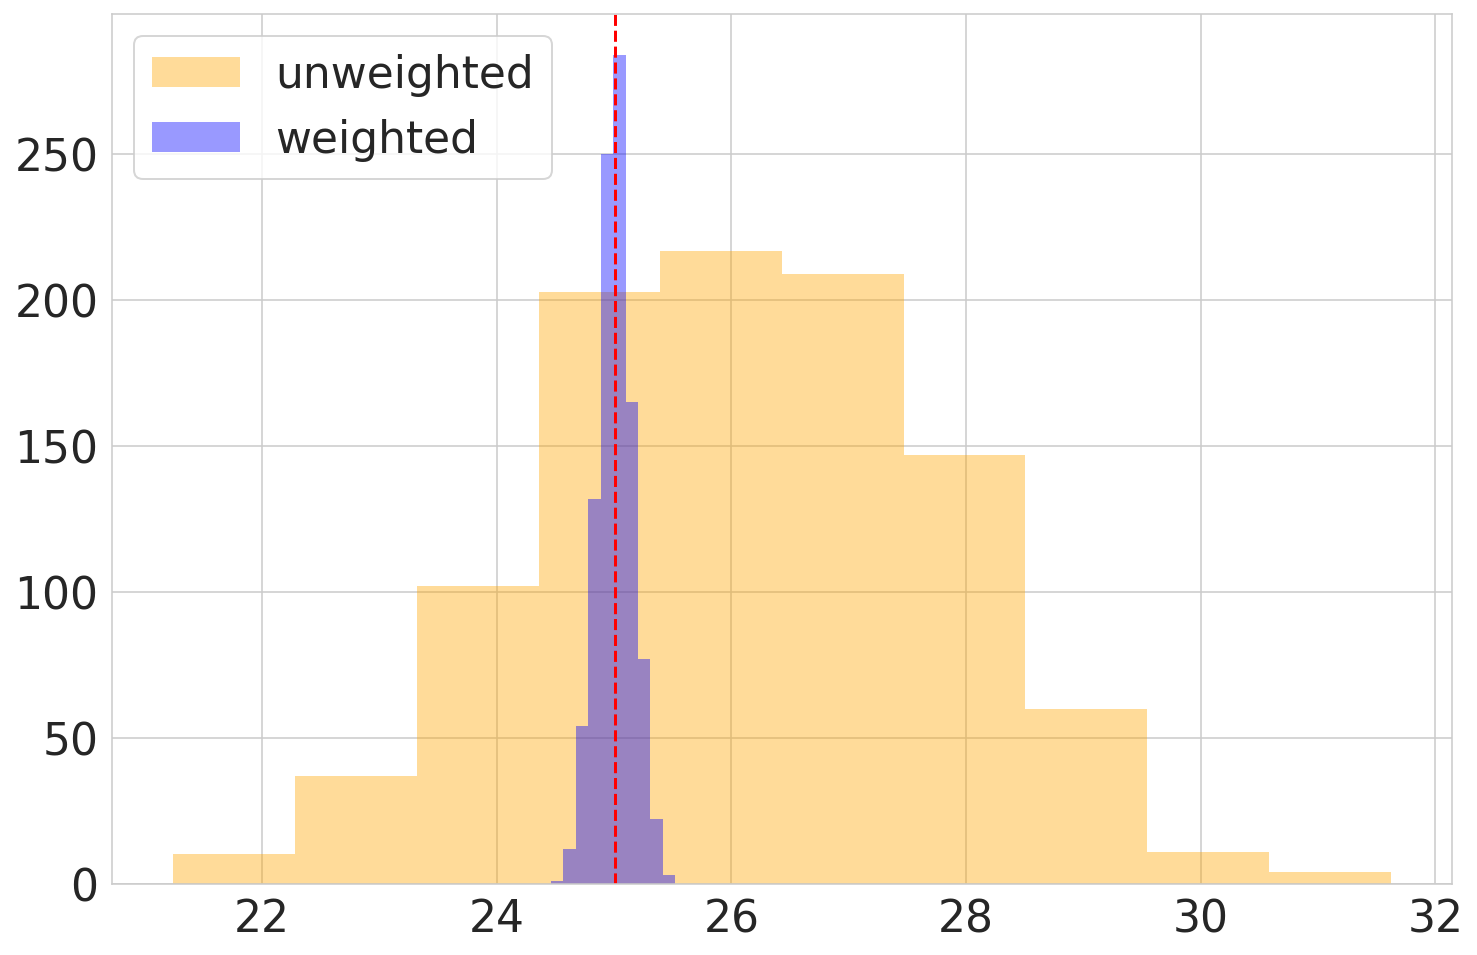

In [13]:
# visually compare unweighted vs weighted estimates.
def compare_estimates(unweighted, weighted, truth,
                      figsize=(12, 8),
                      fontsize=22,
                      output_path=None):
  f = plt.figure(figsize=figsize)
  plt.rcParams.update({'font.size': fontsize})
  plt.hist(unweighted,
           alpha=0.4,
           color='orange',
           edgecolor='none',
           label='unweighted')
  plt.hist(weighted,
           alpha=0.4,
           color='blue',
           edgecolor='none',
           label='weighted')
  plt.axvline(truth, linestyle='dashed', color='red')
  plt.legend(loc='upper left')
  plt.show()
  if output_path is not None:
     f.savefig(output_path, bbox_inches='tight')

compare_estimates(unweighted=result['unweighted'],
                  weighted=result['weighted'],
                  truth=true_mean)